In [1]:
#LOAD USEFULL FUNCTIONS 
noExt=function(x){
return(tools::file_path_sans_ext(x))
}
bnoExt=function(x){
return(basename(tools::file_path_sans_ext(x)))
}
fNumber=function(x){
sapply(x,FUN=function(x){
strsplit(x,"__")[[1]][2]
})
}
rRider=function(x){
sapply(x,FUN=function(x){
strsplit(x,"-RIDER")[[1]][1]
})
}
system("chmod +x /home/Riderv2/callIt.sh")

In [3]:
#LOAD LIBRARIES 
library("argparser");
library(gtools);
library("GenomicRanges");
library("ggVennDiagram");

library(data.table)

In [3]:
#SETTING PATH 
path="/sharedFolder/Data/1_HTGTS/3_JunctionPaper/junction_pooled"
results="/sharedFolder/Results/Hotspot"
system(paste("chmod -R 777 /sharedFolder",sep=""))
dir.create(results,recursive=TRUE)
riderPath="/home/Riderv2/"

Warning message in dir.create(results, recursive = TRUE):
“'/sharedFolder/Results/Hotspot' already exists”


[1] "1__AID_WT_DMSO.bed"
[1] "2__AID_WT_Taze.bed"
[1] "3__AID_WT_Vale.bed"
[1] "4__AID_KO_DMSO.bed"
[1] "5__AID_KO_Taze.bed"
[1] "6__AID_KO_Vale.bed"
[1] "7__Idelalisib_DMSO.bed"
[1] "8__Idelalisib_Taze.bed"
[1] "9__Idelalisib_Vale.bed"
[1] "10__Ligase4_KO_DMSO.bed"
[1] "11__Ligase4_KO_Taze.bed"
[1] "12__Ligase4_KO_Vale.bed"


png 
  2

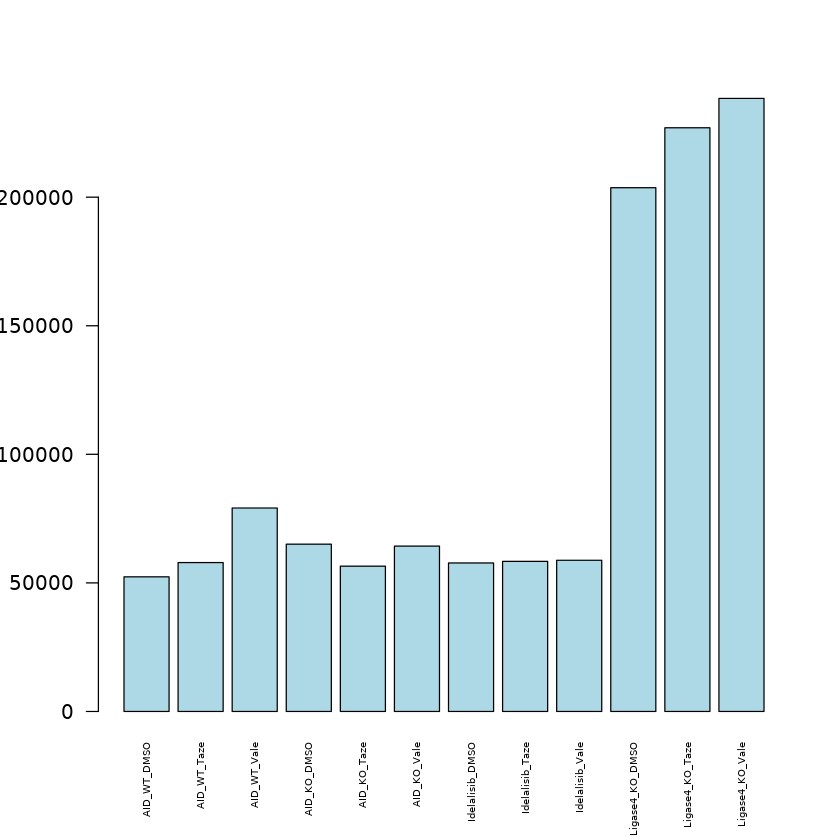

In [4]:
#STEP 0 : evaluate library sizes 
a=list.files(path,pattern=".bed",recursive=TRUE)
a=mixedsort(a)
score=c()
for(i in a){
print(i)
temp=read.table(paste(path,"/",i,sep=""),header=FALSE,sep="\t")
score=append(score,nrow(temp))
}
a2=sapply(a,FUN=function(x){strsplit(x,".bed")[[1]][1]})
a2=sapply(a2,FUN=function(x){strsplit(x,"__")[[1]][2]})
scoreD=data.frame(score=score,names=a2)
options(scipen=10000)
brakes=c()
compile=TRUE
temp=0
while(compile){
brakes=append(brakes,temp)
temp=temp+500
if(temp>max(score)){compile=FALSE}
}
scoreDD=cbind( as.vector(as.matrix(scoreD[2])),scoreD[,1])
rownames(scoreDD)=scoreDD[,1]
junction=scoreD$score
names(junction)=scoreD$names
pdf(paste(results,"/library_size.pdf",sep=""))
barplot(junction,las=2,cex.names=0.5,col="lightblue")
dev.off()
barplot(junction,las=2,cex.names=0.5,col="lightblue")
write.table(scoreDD,paste(results,"/library_size.txt",sep=""),sep="\t",col.names=FALSE,row.names=FALSE,quote=FALSE)

In [5]:
#STEP 1 : Evaluate all hotspots
a=list.files(path,pattern=".bed")
a=mixedsort(a)
setwd(riderPath)
for(i in a){
print("hey")
print(paste(results,"/",fNumber(noExt(i)),sep=""))
dir.create(paste(results,"/",fNumber(noExt(i)),sep=""))
system( paste(riderPath,"/callIt.sh ",path,"/",i," ",results,"/",fNumber(noExt(i)),sep="") )
ff=list.dirs(path,recursive=FALSE,full.names=FALSE)
ff=ff[grep("results",ff)]
ff=paste(path,"/",ff,sep="")
system(paste("mv ",ff," ",results,"/",fNumber(noExt(i)),sep=""))
}

[1] "hey"
[1] "/sharedFolder/Results/Hotspot/AID_WT_DMSO"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/AID_WT_Taze"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/AID_WT_Vale"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/AID_KO_DMSO"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/AID_KO_Taze"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/AID_KO_Vale"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Idelalisib_DMSO"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Idelalisib_Taze"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Idelalisib_Vale"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Ligase4_KO_DMSO"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Ligase4_KO_Taze"
[1] "hey"
[1] "/sharedFolder/Results/Hotspot/Ligase4_KO_Vale"


In [6]:
#STEP 2 : Generating Hotspot Database 
ll=list.files(results,recursive=TRUE,pattern=".txt")
ll=ll[-grep("library_size",ll)]
Database=read.table(paste(results,ll[1],sep="/"),header=TRUE,sep="\t")
Database=Database[,c(2,3,4,14,9)]
Database=Database[1,]
Database=Database[-1,]
colnames(Database)[c(4,5)]=c("Signal2Noise","EventCounts")
HotspotBelonging=c()
for(i in ll){
temp=read.table(paste(results,i,sep="/"),header=TRUE,sep="\t")[,c(2,3,4,14,9)]
colnames(temp)[c(4,5)]=c("Signal2Noise","EventCounts")
Database=rbind(Database,temp)
HotspotBelonging=append(HotspotBelonging,as.vector(rep(rRider(fNumber(bnoExt(i))),nrow(temp))))
}
Database=cbind(Database,HotspotBelonging)


In [7]:
#REMOVING MYC (2 mb) and IGH locus 
db=GRanges(seqnames=as.matrix(Database[,1]),ranges=IRanges(start = as.numeric(Database[,2])-100,end=as.numeric(Database[,3])+100))
myc=GRanges(seqnames="chr15",ranges=IRanges(start=60562682,end=63076130))
toRemove=findOverlaps(myc,db)@to
igh=GRanges(seqnames="chr12",ranges=IRanges(start=114419999,end=114680000))
toRemove=append(toRemove,findOverlaps(igh,db)@to)
Database=Database[-toRemove,]


In [8]:
#Standardize the Database with proper length and proper count, and proper rpm
db=GRanges(seqnames=as.matrix(Database[,1]),ranges=IRanges(start = as.numeric(Database[,2]),end=as.numeric(Database[,3])))
db=reduce(db)
for(i in seq(1,nrow(Database))){
grI=GRanges(seqnames=as.matrix(Database[i,1]),ranges=IRanges(start=as.numeric(Database[i,2]),end=as.numeric(Database[i,3])))
Database[i,1]=as.vector((db[findOverlaps(db,grI)@from]@seqnames)@values)
Database[i,2]=as.numeric((db[findOverlaps(db,grI)@from]@ranges)@start)
Database[i,3]=Database[i,2]+as.numeric((db[findOverlaps(db,grI)@from]@ranges)@width)-1
}

for(i in a){
temp=read.table(paste(path,"/",i,sep=""),header=FALSE,sep="\t")
tempbed=GRanges(seqnames=as.matrix(temp[,1]),ranges=IRanges(start = as.numeric(temp[,2]),end=as.numeric(temp[,3])))
for(j in seq(1,nrow(Database))){
if(Database[j,6]==as.vector(fNumber(noExt(i)))){
db2=GRanges(seqnames=as.matrix(Database[j,1]),ranges=IRanges(start = as.numeric(Database[j,2]),end=as.numeric(Database[j,3])))
Database[j,5]=countOverlaps(db2,tempbed)
Database[j,4]=(Database[j,5]/nrow(temp))*1000000
}


}
system("echo yeah")
}

In [9]:
#Add unique ID_LIST to Database  
hh=GRanges(seqnames=as.matrix(Database[,1]),ranges=IRanges(start = as.numeric(Database[,2])-100,end=as.numeric(Database[,3])+100))
positions=numeric(length(hh))
for(i in seq(hh)){
if(length(findOverlaps(hh,hh[i]))!=0){
positions[findOverlaps(hh,hh[i])@from]=i
}else{
positions[i]=i
}
system("echo yeah")
}
Database=cbind(Database,positions)
colnames(Database)[7]="hotspotID"
#DATABASE contains all Hotspots in all conditions with : 
#Chromosome	ChrStart	ChrEnd	Signal2Noise	EventCounts	HotspotBelonging	hotspotID

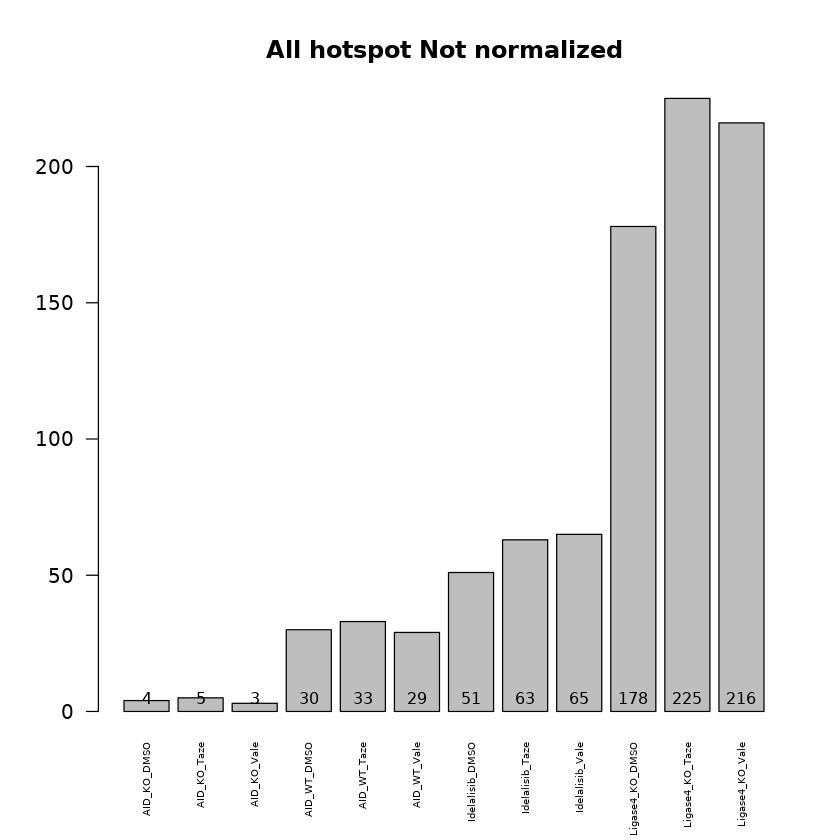

png 
  2

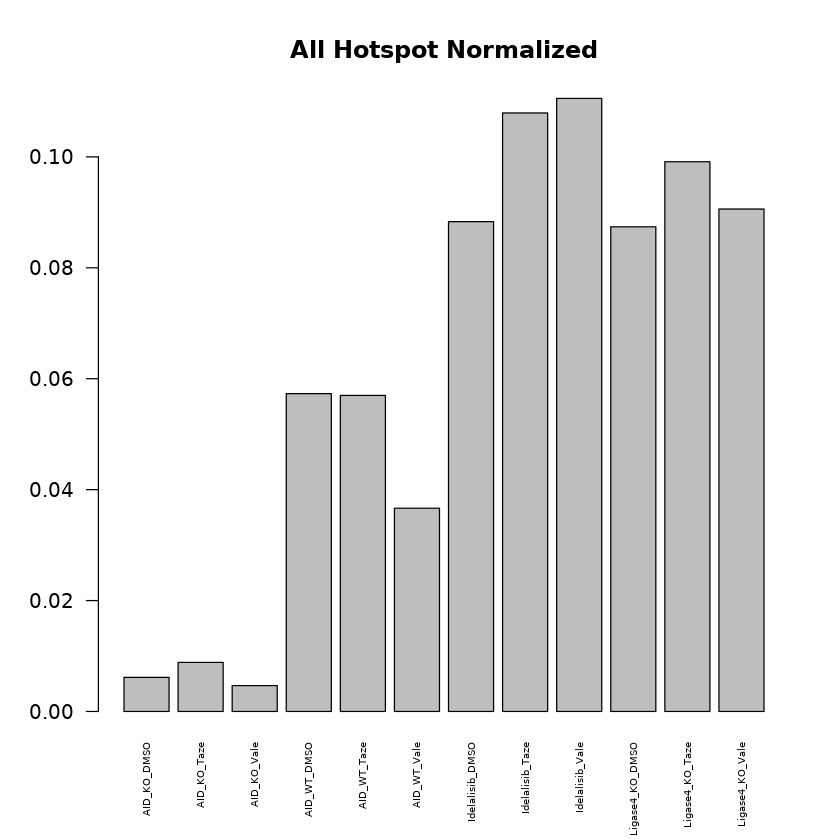

In [10]:
#Plot hotspot statistic Normalized and not 
Database2=Database[!duplicated(Database),]
bb=barplot(table(Database2[,6]),main="All hotspot Not normalized",cex.names=0.5,las=2)
text(bb,5,table(Database2[,6]),cex=.8)
normalized=(table(Database2[,6])/as.numeric(scoreDD[names(table(Database2[,6])),2])*100)
bb=barplot(normalized,main="All Hotspot Normalized",cex.names=0.5,las=2)
pdf(paste(results,"/HotspotNumber.pdf",sep=""))
bb=barplot(table(Database2[,6]),main="All Hotspot Not normalized",cex.names=0.5,las=2)
text(bb,5,table(Database2[,6]),cex=.8)
normalized=(table(Database2[,6])/as.numeric(scoreDD[names(table(Database2[,6])),2])*100)
bb=barplot(normalized,main="All Hotspot Normalized",cex.names=0.5,las=2)
dev.off()

[1] 750 900
[1] 750 900
[1] 750 900
[1]   6   2 778 900
[1] 721   6 750 778 900
[1]  10 778 900


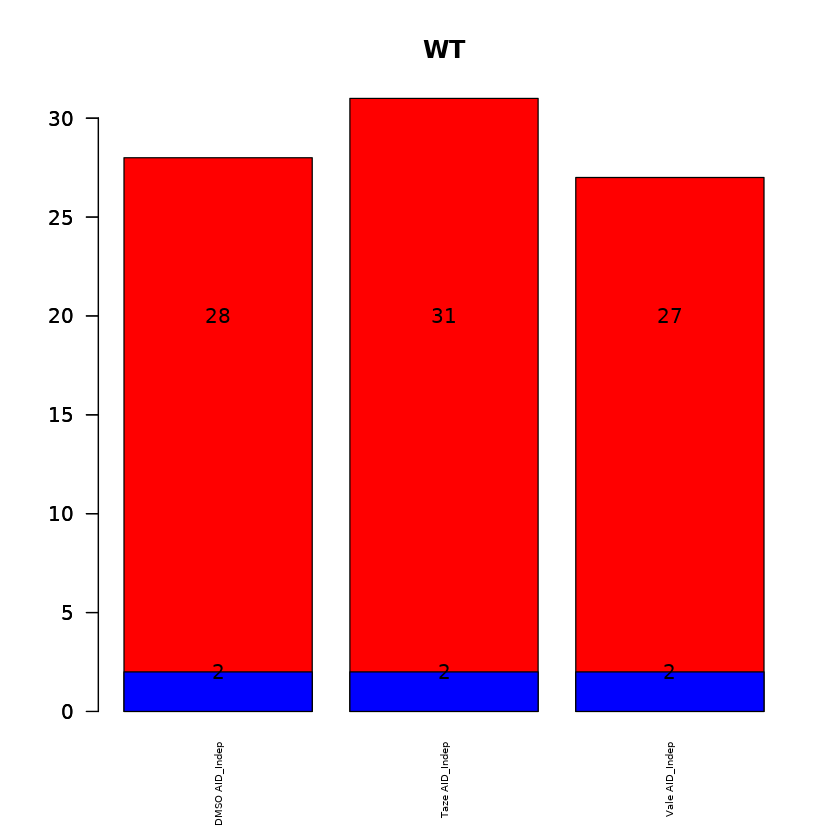

[1] 721 750 900
[1] 721 750 778 900
[1] 778 900


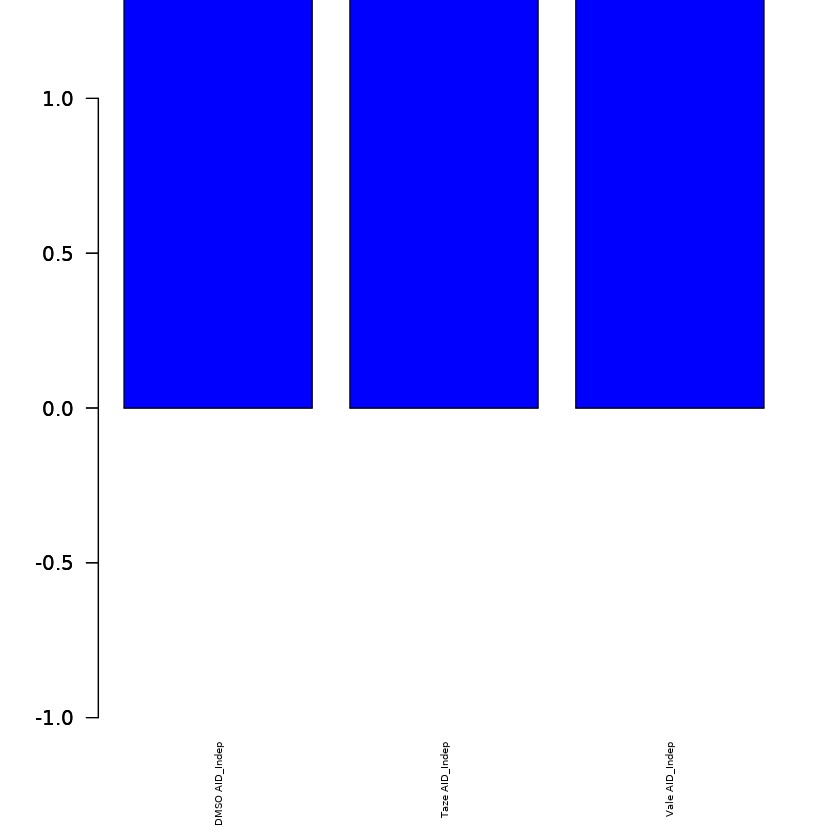

[1] 721 750 778 900
[1] 721 750 778 900
[1] 721 750 778 900


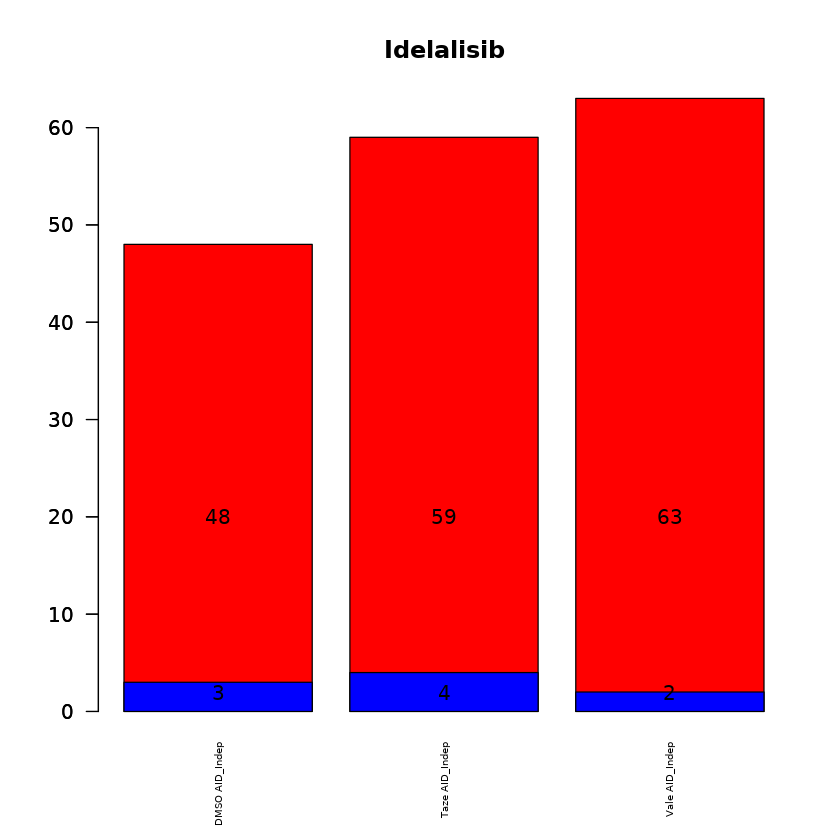

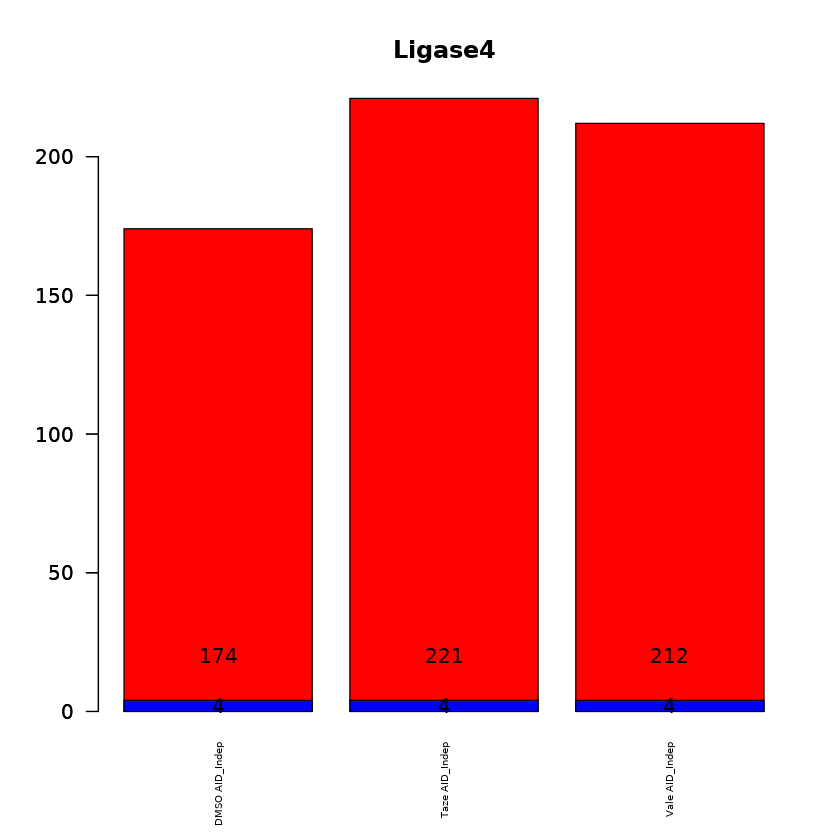

In [11]:
types=c("AID_KO","Idelalisib","WT","Ligase4")

tabletabletable=matrix(ncol=3)
colnames(tabletabletable)=c("Aid onTarget","Aid off Target","Aid Indep")

AIDH=Database[grep(types[1],Database[,6]),7]
AIDINDependent=c()
for(j in types[c(3,1,2,4)]){
subBase=Database[grep(j,Database[,6]),]
h1=list()
h2=list()
count=1
names1=c()
names2=c()
yoloh=c()
conditions=c("DMSO","Taze","Vale")

for(i in conditions){

subBase2=subBase[grep(i,subBase[,6]),]
print(c(intersect(subBase2[,7],AIDH)))
yoloh=append(yoloh,c(intersect(subBase2[,7],AIDH)))
h1[[count]]=length(c(intersect(subBase2[,7],AIDH)))
names1=append(names1,paste(i,"AID_indep"))
h2[[count]]=length(c(setdiff(subBase2[,7],AIDH)))   
names2=append(names2,paste(i,"AID_Indep"))
count=count+1
AIDINDependent=append(AIDINDependent,intersect(subBase2[,7],AIDH))
}


bb=barplot(as.numeric(h2), width = 0.5,  col='red',main=j,las=2,names=names2,cex.names=0.5)
bb2=barplot(as.numeric(h1), width = 0.5, col='blue', add=T,main=j,las=2,cex.names=0.5)
text(bb,20,as.numeric(h2))
text(bb2,2,as.numeric(h1))
pdf(paste(results,"/",j,"HOTSPOT.pdf",sep=""))
bb=barplot(as.numeric(h2), width = 0.5,  col='red',main=j,las=2,names=names2,cex.names=0.5)
bb2=barplot(as.numeric(h1), width = 0.5, col='blue', add=T,main=j,las=2,cex.names=0.5)
text(bb,90,as.numeric(h2))
text(bb2,4,as.numeric(h1))    
dev.off()

aidIND=matrix(ncol=ncol(Database))
colnames(aidIND)=colnames(Database)
for(i in AIDINDependent){
aidIND=rbind(aidIND,Database[which(Database[,7]==i)[1],])
}
aidIND=aidIND[-1,-c(4,5,6)]
write.table(unique(aidIND),paste(results,"/HOTSPOT_AIDINDEPENDENT.csv",sep=""),sep=",",row.names=FALSE)
yoloh=unique(yoloh)
tabletable=cbind(5,h2,h1)
rownames(tabletable)=paste(c("DMSO","Taze","Vale"),j,sep="")
colnames(tabletable)=c("Aid onTarget","Aid off Target","Aid Indep")
tabletabletable=rbind(tabletabletable,tabletable)
    }
tabletabletable=tabletabletable[-1,]
write.table(tabletabletable,paste(results,"/barplot.csv",sep=""),sep=",",col.names=NA)
for(i in unique(aidIND)[,4]){
Database=Database[-which(Database[,7]==i),]
}

In [12]:
Database=Database[!duplicated(Database),]
write.table(Database[,c(1,2,3)],paste(results,"/hotSpot.bed",sep=""),col.names=FALSE,row.names=FALSE,sep="\t",quote=FALSE)
write.table(Database,paste(results,"/Database.csv",sep=""),sep=",",col.names=TRUE,row.names=FALSE)


[1] "1__AID-WT_DMSO.bed"
[1] "2__AID-WT_DMSO.bed"
[1] "3__AID-WT_DMSO.bed"
[1] "4__AID-WT_DMSO.bed"
[1] "5__AID-WT_DMSO.bed"
[1] "6__AID-WT_Taze.bed"
[1] "7__AID-WT_Taze.bed"
[1] "8__AID-WT_Taze.bed"
[1] "9__AID-WT_Taze.bed"
[1] "10__AID-WT_Taze.bed"
[1] "11__AID-WT_Valemetostat-1.bed"
[1] "12__AID-WT_Valemetostat-2.bed"
[1] "13__AID-WT_Valemetostat-3.bed"
[1] "14__AID-WT_Valemetostat-4.bed"
[1] "15__AID-WT_Valemetostat-5.bed"
[1] "16__AID-WT_Valemetostat-6.bed"
[1] "17__AID-WT_Valemetostat-7.bed"
[1] "18__AID-WT_Valemetostat-8.bed"
[1] "19__AID-KO_DMSO.bed"
[1] "20__AID-KO_DMSO.bed"
[1] "21__AID-KO_DMSO.bed"
[1] "22__AID-KO_DMSO.bed"
[1] "23__AID-KO_Taze.bed"
[1] "24__AID-KO_Taze.bed"
[1] "25__AID-KO_Taze.bed"
[1] "26__AID-KO_Taze.bed"
[1] "28__AID-KO_Vale.bed"
[1] "29__AID-KO_Vale.bed"
[1] "30__AID-KO_Vale.bed"
[1] "31__Idelalisib_DMSO1.bed"
[1] "32__Idelalisib_DMSO2.bed"
[1] "33__Idelalisib_DMSO3.bed"
[1] "34__Idelalisib_DMSO4.bed"
[1] "35__Idelalisib_DMSO5.bed"
[1] "36__Idelalisib_

png 
  2

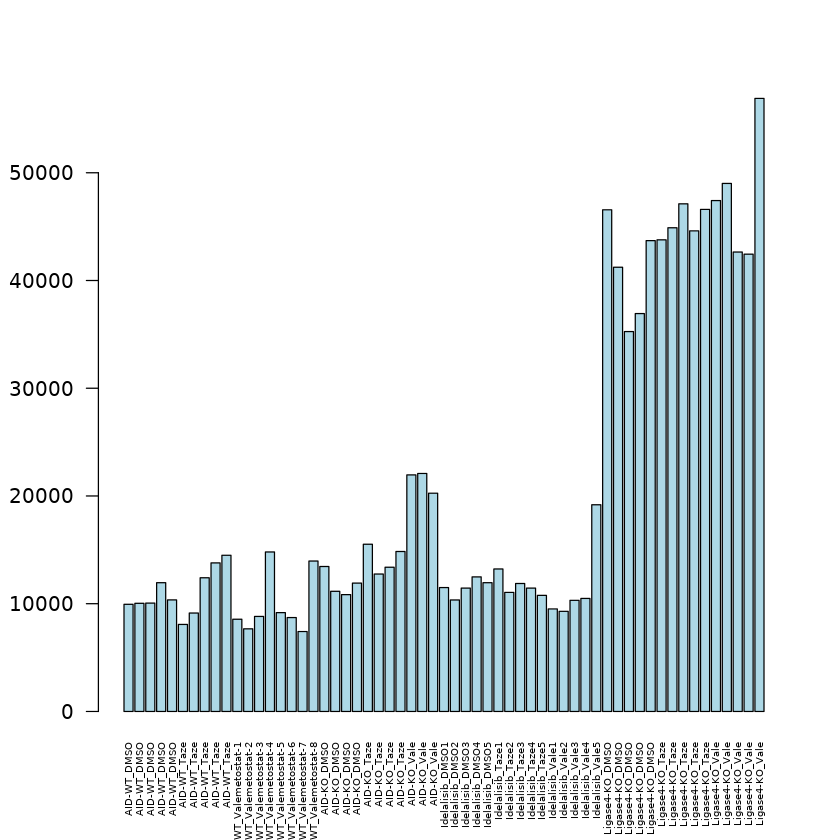

In [13]:
#STEP 0 : evaluate library sizes 
path2="/sharedFolder/Data/1_HTGTS/3_JunctionPaper/junction_singles"
a=list.files(path2,pattern=".bed",recursive=TRUE)
a=mixedsort(a)
score=c()
for(i in a){
print(i)
temp=read.table(paste(path2,"/",i,sep=""),header=FALSE,sep="\t")
score=append(score,nrow(temp))
}
a2=sapply(a,FUN=function(x){strsplit(x,".bed")[[1]][1]})
a2=sapply(a2,FUN=function(x){strsplit(x,"__")[[1]][2]})
scoreD=data.frame(score=score,names=a2)
options(scipen=10000)
brakes=c()
compile=TRUE
temp=0
while(compile){
brakes=append(brakes,temp)
temp=temp+500
if(temp>max(score)){compile=FALSE}
}
scoreDD=cbind( as.vector(as.matrix(scoreD[2])),scoreD[,1])
rownames(scoreDD)=scoreDD[,1]
junction=scoreD$score
names(junction)=scoreD$names
pdf(paste(results,"/library_size.pdf",sep=""))
barplot(junction,las=2,cex.names=0.5,col="lightblue")
dev.off()
barplot(junction,las=2,cex.names=0.5,col="lightblue")
write.table(scoreDD,paste(results,"/library_sizeSingles.txt",sep=""),sep="\t",col.names=FALSE,row.names=FALSE,quote=FALSE)

In [11]:
data <- fread(paste(results,"/Database_annotated.csv",sep=""))

# Seleziona solo le colonne necessarie per il plot
data <- data[, c("Chromosome", "ChrStart", "ChrEnd")]

# Crea un dataframe per il plot
plot_data <- data.frame(
  chr = data$Chromosome,
  start = data$ChrStart,
  end = data$ChrEnd,
  stringsAsFactors = FALSE
)

# Create a vector of unique chromosome names
chromosomes <- unique(plot_data$chr)

# Define the ideogram positions and labels
ideograms <- list()
for (i in 1:length(chromosomes)) {
  ideograms[[i]] <- ideogram(
    chromosome = chromosomes[i],
    start = 0,
    end = max(plot_data$end[plot_data$chr == chromosomes[i]]),
    labels.track.height = 0.1,
    track.height = 0.2
  )
}

# Create the circular plot
circos.par(cell.padding = c(0, 0, 0, 0))
circos.initialize(factors = chromosomes, xlim = c(0, max(plot_data$end)), ideogram = ideograms)
circos.trackPlotRegion(ylim = c(0, 1))
circos.genomicTrack(plot_data, panel.fun = function(region, value, ...) {
  circos.lines(region, value, ...)
}, track.height = 0.2, bg.border = NA)

# Save the plot to a file
circos.clear()
pdf("circular_plot.pdf")
circos.genomicTrack(plot_data, panel.fun = function(region, value, ...) {
  circos.lines(region, value, ...)
}, track.height = 0.2, bg.border = NA)
dev.off()

ERROR: Error in ideogram(chromosome = chromosomes[i], start = 0, end = max(plot_data$end[plot_data$chr == : could not find function "ideogram"


In [14]:
#FINISH